In [82]:
import numpy as np
import ast

# Read the file contents
with open('data.txt', 'r') as file:
    data = file.read()

# Use ast.literal_eval to safely evaluate the string to a Python object
arrays_list = ast.literal_eval(data)

# Convert the list of lists to a list of numpy arrays
# arrays_list = [np.array(arr) for arr in arrays_list]

# # Print the result to verify
# for arr in arrays_list:
#     print(arr)


ValueError: malformed node or string: <_ast.Call object at 0x000002BC343216A0>

In [49]:
'''
Author: Mattia Fabiani
Update: This version of the main allows the grouping of the results by SNR values.
'''

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import argparse
import os

# parser = argparse.ArgumentParser()
# parser.add_argument('--id', type=str,                   default='', help='Unique experiment identifier')
# parser.add_argument('--N', type=int,                    default=128, help='Number of antennas.')
# # parser.add_argument('--N_RF', type=int,                 default=16, help='Number of RF chains.')
# parser.add_argument('--generate_dataset', type=int,     default=0, help='Generate Dataset.')
# parser.add_argument('--logdir', type=str,               default='saved_models', help='Directory to log data to')
# args = parser.parse_args()
# foldername = str(args.epochs)+'epochs_'+str(args.batch_size)+'batch_'+'model'+str(args.model)+'_lr'+str(args.lr)+'_'
# args.logdir = os.path.join(args.logdir, foldername + args.id)

#---------- SIMULATION PARAMETERS -----------
f0 = 25e9                   # carrier frequency
k = 2*np.pi / (3e8 / f0)    # wave number
c = 3e8
wavelength = c / f0  # Lunghezza d'onda
d = wavelength / 2              # antenna spacing
N = 128                     # antennas
SNR_dB = list(range(0,25,5))
SNR = [10 ** (SNR / 10) for SNR in SNR_dB]

range_limits = [1, 20]      # near-field range limits [m]
rng_seed = 42
#------------------------------------------

np.random.seed(rng_seed)
def CN_realization(mean, std_dev, size=1):
    return np.random.normal(mean, std_dev, size) + 1j * np.random.normal(mean, std_dev, size)
delta = lambda n: (2*n - N + 1)/2
a = lambda theta, r: np.array([np.exp(-1j*k*(np.sqrt(r**2 + delta(n)**2*d**2 - 2*r*theta*delta(n)*d) - r)) for n in range(N)]).T
i = 0
snr = SNR[-1] # 20 dB
sigma_n = 1 / np.sqrt(snr)
s = CN_realization(mean=0, std_dev=1)
n = CN_realization(mean=0, std_dev=sigma_n, size=N)

r = np.random.uniform(range_limits[0], range_limits[1])
theta = np.random.uniform(-1,1)
# theta = 0.5

# uplink received signal
r = 15
true_angle = np.radians(-45)
theta = np.sin(true_angle)
y = a(theta,r) * s + n
y = a(theta,r)

d = 0.5  # Spaziatura tra le antenne in lunghezze d'onda
ang_grid = np.linspace(-np.pi/2, np.pi/2, 180)  # Angoli di scansione
range_grid = np.linspace(range_limits[0], range_limits[1], 50)  # Angoli di scansione

ML_bins = np.zeros((len(ang_grid),len(range_grid)),dtype=float)
for i, ang in enumerate(ang_grid):
    for j, rng in enumerate(range_grid):
        y_test = a(np.sin(ang),rng) * s
        # ML_bins[i,j] = np.abs(np.dot(y,np.conj(y_test)))**2
        ML_bins[i,j] = np.abs(np.dot(y,y_test))**2
        # print(ML_bins)
        # exit()

range: 12.24, angle: -84.97
range_gt: 15.00, angle: -45.0


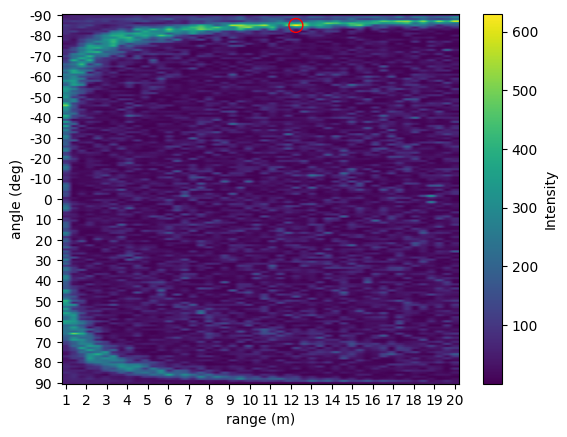

In [50]:
idx_ang,idx_range = np.unravel_index(np.argmax(ML_bins), ML_bins.shape)
print(f'range: {range_grid[idx_range]:.2f}, angle: {ang_grid[idx_ang]/np.pi*180:.2f}'
      f'\nrange_gt: {r:.2f}, angle: {true_angle/np.pi*180}')
# plt.imshow(10*np.log10(ML_bins), aspect='auto', cmap='viridis') # vmax = 2
plt.scatter(idx_range,idx_ang,facecolors='none', edgecolors='red',s=100)
plt.imshow(ML_bins, aspect='auto', cmap='viridis') # vmax = 2
plt.colorbar(label='Intensity')
plt.xlabel('range (m)')
plt.ylabel('angle (deg)')
x_label, y_label = np.arange(1, 21, 1), np.arange(-90, 91, 10)
plt.yticks(np.linspace(0,ML_bins.shape[0]-1,len(y_label)) ,labels=y_label)
plt.xticks(np.linspace(0,ML_bins.shape[1]-1,len(x_label)) ,labels=x_label)
plt.show()

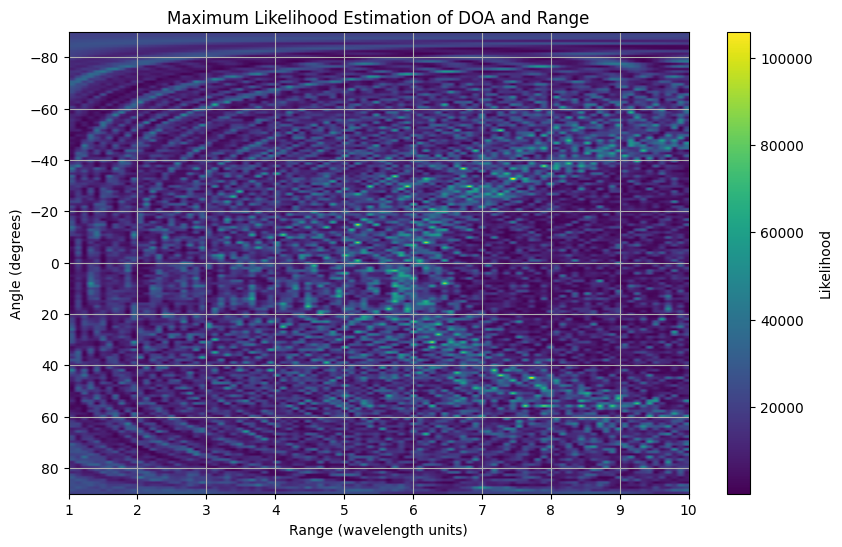

Estimated DOA: -33.00 degrees
Estimated Range: 7.45 wavelength units


In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_elements = 128
element_spacing = 0.5  # half wavelength spacing
SNR_dB = 20
fc = 28e9
SNR_linear = 10**(SNR_dB / 10)
true_DOA = 45  # true direction of arrival in degrees
true_range = 5  # true range in wavelength units
num_samples = 10  # number of samples

# Generate the array response vector for the true DOA and range
def array_response_vector_nearfield(theta, r, num_elements, element_spacing):
    wavelength = 3e8/fc  # assuming wavelength is 1 unit
    k = 2 * np.pi / wavelength
    angles = np.arange(num_elements) * element_spacing
    distances = np.sqrt((angles - r * np.sin(np.radians(theta)))**2 + (r * np.cos(np.radians(theta)))**2)
    return np.exp(1j * k * distances)

# Generate the received signal with noise
np.random.seed(0)
signal = array_response_vector_nearfield(true_DOA, true_range, num_elements, element_spacing)
noise = (np.random.randn(num_samples, num_elements) + 1j * np.random.randn(num_samples, num_elements)) / np.sqrt(2)
noise_power = np.var(noise)
signal_power = noise_power * SNR_linear
received_signal = np.sqrt(signal_power) * signal + noise

# Compute the sample covariance matrix
R = (received_signal.conj().T @ received_signal) / num_samples

# Maximum Likelihood Estimation
theta_scan = np.linspace(-90, 90, 181)  # scan angles from -90 to 90 degrees
range_scan = np.linspace(1, 10, 100)  # scan ranges from 1 to 10 wavelength units
likelihood = np.zeros((len(theta_scan), len(range_scan)), dtype=float)

for i, theta in enumerate(theta_scan):
    for j, r in enumerate(range_scan):
        steering_vector = array_response_vector_nearfield(theta, r, num_elements, element_spacing)
        likelihood[i, j] = np.abs(steering_vector.conj().T @ R @ steering_vector)

max_likelihood_idx = np.unravel_index(np.argmax(likelihood), likelihood.shape)
estimated_DOA = theta_scan[max_likelihood_idx[0]]
estimated_range = range_scan[max_likelihood_idx[1]]

# Plot the likelihood function
plt.figure(figsize=(10, 6))
plt.imshow(likelihood, extent=[range_scan[0], range_scan[-1], theta_scan[-1], theta_scan[0]], aspect='auto', cmap='viridis')
plt.colorbar(label='Likelihood')
plt.xlabel('Range (wavelength units)')
plt.ylabel('Angle (degrees)')
plt.title('Maximum Likelihood Estimation of DOA and Range')
# plt.scatter(estimated_range, estimated_DOA, color='red', label=f'Estimated: {estimated_DOA:.2f}°, {estimated_range:.2f} units')
# plt.legend()
plt.grid(True)
plt.show()

print(f'Estimated DOA: {estimated_DOA:.2f} degrees')
print(f'Estimated Range: {estimated_range:.2f} wavelength units')


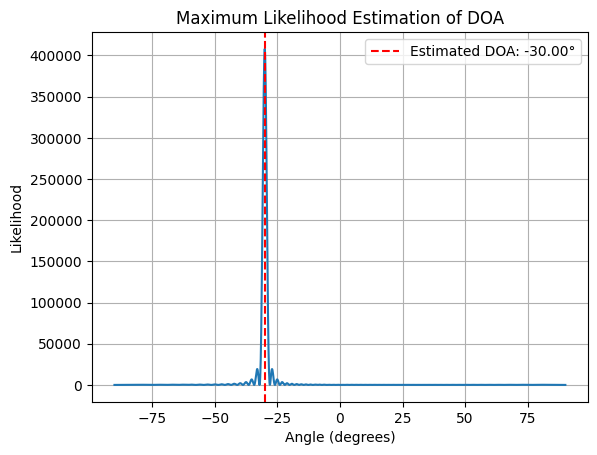

Estimated DOA: -30.00 degrees


In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_elements = 64
element_spacing = 0.5  # half wavelength spacing
SNR_dB = 20
SNR_linear = 10**(SNR_dB / 10)
true_DOA = 30  # true direction of arrival in degrees
num_samples = 1000  # number of samples

# Generate the array response vector for the true DOA
def array_response_vector(theta, num_elements, element_spacing):
    wavelength = 1  # assuming wavelength is 1 unit
    k = 2 * np.pi / wavelength
    angles = np.arange(num_elements) * element_spacing
    return np.exp(1j * k * angles * np.sin(np.radians(theta)))

# Generate the received signal with noise
np.random.seed(0)
signal = array_response_vector(true_DOA, num_elements, element_spacing)
noise = (np.random.randn(num_samples, num_elements) + 1j * np.random.randn(num_samples, num_elements)) / np.sqrt(2)
noise_power = np.var(noise)
signal_power = noise_power * SNR_linear
received_signal = np.sqrt(signal_power) * signal + noise

# Compute the sample covariance matrix
R = (received_signal.conj().T @ received_signal) / num_samples

# Maximum Likelihood Estimation
theta_scan = np.linspace(-90, 90, 1801)  # scan angles from -90 to 90 degrees
likelihood = np.zeros_like(theta_scan, dtype=float)

for i, theta in enumerate(theta_scan):
    steering_vector = array_response_vector(theta, num_elements, element_spacing)
    likelihood[i] = np.abs(steering_vector.conj().T @ R @ steering_vector)

estimated_DOA = theta_scan[np.argmax(likelihood)]

# Plot the likelihood function
plt.plot(theta_scan, likelihood)
plt.title('Maximum Likelihood Estimation of DOA')
plt.xlabel('Angle (degrees)')
plt.ylabel('Likelihood')
plt.grid(True)
plt.axvline(x=estimated_DOA, color='r', linestyle='--', label=f'Estimated DOA: {estimated_DOA:.2f}°')
plt.legend()
plt.show()

print(f'Estimated DOA: {estimated_DOA:.2f} degrees')


In [ ]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import torch
import pandas as pd
import torch.optim as optim
import os
from torch.utils.data import DataLoader
from dnn_model import DNN_model
from network_functions import train_loop, eval_loop, test_loop, evaluate_predictions

dataset_root = 'dataset/'
dataset_path = os.path.join(dataset_root,'dataset.npy')

# Load Data
dataset = np.load(dataset_path,allow_pickle=True).item()
print("Dataset loaded successfully.")


In [ ]:
polar_cord = np.array([dataset[i]['y'] for i in range(10000)])
ang = np.arcsin(polar_cord[:,0])
plt.polar(ang,polar_cord[:,1],'ko',markersize=1)

In [ ]:
from dnn_model import *
import numpy as np

N = 4
N_RF = 2

net = DNN_model(N=N,N_RF=N_RF)


for name, params in net.named_parameters():
    if 'weight' in name and 'fc1' in name:
        print('Weights fc1 BEFORE weights update')
        print(params.detach())
        # w = params[:N_RF/2,:N] + 1j*params[N_RF/2:N_RF,:N]
        # sum_weights = np.sum(np.abs(w.detach().numpy())**2)
        # print(sum_weights)

constraints = weightConstraint(N,N_RF,'sub-connected') # per-antenna power constraint (eq 5d)
net._modules['fc1'].apply(constraints)


for name, params in net.named_parameters():
    if 'weight' in name and 'fc1' in name:
        print('\nWeights fc1 AFTER weights update')
        print(params.detach())
        w = params[:N_RF,:N] + 1j*params[N_RF:2*N_RF,N:2*N]
        w = params[0,0] + 1j*params[2,4]
        abs_w = np.abs(w.detach().numpy())**2
        print(abs_w)

In [ ]:
SNR_dB = list(range(0,25,5))
SNR = [10 ** (SNR / 10) for SNR in SNR_dB]
train_val_split, val_split = 0.8, 0.1
test_split = 0.1
dataset_size = 10000
train_dim = int(train_val_split*dataset_size*len(SNR))
val_dim = int(val_split*dataset_size*len(SNR))
test_dim = int(test_split*dataset_size*len(SNR))
Xy_train = [dataset[i] for i in range(train_dim)]
df1 = pd.DataFrame([{key: value for key, value in record.items()} for record in Xy_train])

# X_train, y_train = np.array([dataset[i][['X', 'SNR']] for i in range(train_dim)]), np.array([dataset[i]['y', 'SNR'] for i in range(train_dim)])

In [ ]:
X_test, y_test = np.array([dataset[i] for i in range(train_dim+val_dim,train_dim+val_dim + test_dim)]), np.array([dataset[i]['y'] for i in range(train_dim+val_dim,train_dim+val_dim + test_dim)])


In [ ]:
keys = ['y', 'SNR']
values = list(map(dataset[0].get,keys) )
print(values)


In [ ]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import os
from torch.utils.data import DataLoader
from dnn_model import DNN_model
from network_functions import train_loop, eval_loop, test_loop, evaluate_predictions


#---------- SIMULATION PARAMETERS -----------
f0 = 25e9                   # carrier frequency
k = 2*np.pi / (3e8 / f0)    # wave number
d = 3e8/f0 / 2              # antenna spacing
N = 128                     # antennas
N_RF = 16                   # RF chains
SNR_dB = list(range(0,25,5))
SNR = [10 ** (SNR / 10) for SNR in SNR_dB]

range_limits = [1, 20]      # near-field range limits [m]

dataset_size = 10000        # number of signals per SNR (10k * 5 = 50k samples in ottal)
generate_dataset = False
train = False
epochs = 50
batch_size = 32
lr = 1e-2
train_val_split = 0.8
val_split = 0.1
test_split = 0.1
dataset_root = 'dataset/'
dataset_path = os.path.join(dataset_root,'dataset.npy')
models = [DNN_model]        # create a list of models if more than one are developed
rng_seed = 42
# Load Data
dataset = np.load(dataset_path,allow_pickle=True).item()
print("Dataset loaded successfully.")

train_dim = int(train_val_split*dataset_size*len(SNR))
val_dim = int(val_split*dataset_size*len(SNR))
test_dim = int(test_split*dataset_size*len(SNR))

X_train, y_train = np.array([dataset[i]['X'] for i in range(train_dim)]), np.array([dataset[i]['y'] for i in range(train_dim)])
X_val, y_val = np.array([dataset[i]['X'] for i in range(train_dim,train_dim+val_dim)]), np.array([dataset[i]['y'] for i in range(train_dim,train_dim+val_dim)])
# X_test, y_test = np.array([dataset[i]['X'] for i in range(train_dim+val_dim,train_dim+val_dim + test_dim)]), np.array([dataset[i]['y'] for i in range(train_dim+val_dim,train_dim+val_dim + test_dim)])
X_test, y_test = np.array([dataset[i] for i in range(train_dim+val_dim,train_dim+val_dim + test_dim)]), np.array([dataset[i]['y'] for i in range(train_dim+val_dim,train_dim+val_dim + test_dim)])

print('train set: ',len(X_train))
print('val set: ',len(X_val))
print('test set: ',len(X_test))
# X_test = np.array([dataset[i]['X'] for i in range(train_dim+val_dim,train_dim+val_dim + test_dim)])

# xy_test = [dataset[i] for i in range(train_dim+val_dim,train_dim+val_dim + test_dim)]
# df_test = pd.DataFrame([{key: value for key, value in record.items()} for record in xy_test])
# y_test = df_test[['y','SNR']].to_numpy()
# print(np.array(df_test[['X']].values).squeeze().shape)
# X_test = torch.tensor(X_test).float()
# exit()

# PyTorch Tensors
X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()
# X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_val = torch.tensor(y_val).float()
# y_test = torch.tensor(y_test).float()


# PyTorch GPU/CPU selection
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Testing..')
# topk=5
model_directory = 'saved_models/type0_batchsize32_rng42_epoch50_v0'
model = models[0](N,N_RF)

In [ ]:

xy_test = [dataset[i] for i in range(train_dim+val_dim,train_dim+val_dim + test_dim)]
df_test = pd.DataFrame([{key: value for key, value in record.items()} for record in xy_test])
y_test = np.array(df_test['y'])
y_test_snr = np.array(df_test['SNR'].values)


## Separate results by SNR values

In this case, a dataframe object is created from the training set. Only the rows containing SNR = 1.0 are considered.

In [ ]:
# X_train[:2] # contains the keys SNR, X and y. how can I convert it to a dataframe? and visualize with df1.head()
df1 = pd.DataFrame([{key: value for key, value in record.items()} for record in X_train])
df1[df1['SNR'] == 1].reset_index(drop=True)


In [ ]:
foldername = 'saved_models/type0_batchsize64_rng42_epoch50_v0/'
train_rmse_r = np.load(foldername + 'train_rmse_r.npy',allow_pickle=True)
train_rmse_theta = np.load(foldername + 'train_rmse_theta.npy',allow_pickle=True)
train_rmse_pos = np.load(foldername + 'train_rmse_pos.npy',allow_pickle=True)

val_rmse_r = np.load(foldername + 'val_rmse_r.npy',allow_pickle=True)
val_rmse_theta = np.load(foldername + 'val_rmse_theta.npy',allow_pickle=True)
val_rmse_pos = np.load(foldername + 'val_rmse_pos.npy',allow_pickle=True)

fig, ax = plt.subplots(1,3)
ax[0].plot(train_rmse_r,'k-',label='RMSE (r) train')
ax[0].plot(val_rmse_r,'r-',label='RMSE (r) val')
ax[1].plot(train_rmse_theta,'k-',label='RMSE (theta) train')
ax[1].plot(val_rmse_theta,'r-',label='RMSE (theta) val')
ax[2].plot(train_rmse_pos,'k-',label='RMSE (pos) train')
ax[2].plot(val_rmse_pos,'r-',label='RMSE (pos) val')